In [1]:
#%cd /mnt/home/acanatar/jupyter/spectral_moment/TVSD
%cd /mnt/home/cchun/projects/spectral_moment/TVSD

from data_utils import get_tvsd_dataset, load_data
from moment_utils import getest_all

DATAROOT = '/mnt/ceph/users/acanatar'

/mnt/home/cchun/projects/spectral_moment/TVSD


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [3]:
data = load_data(DATAROOT, session='test')

sub_names = ['F', 'N']
roi_names = ['V1', 'V4', 'IT']

roi_data = {}
for sub_name in sub_names:

    roi_data[sub_name] = {}
    for roi_name in roi_names:
        roi = np.asarray(data[sub_name]['df'][roi_name].tolist())
        roi_data[sub_name][roi_name] = roi

In [39]:
sub_name = 'N'

Q_values = [10, 15, 25, 50, 100, 192]
num_repeat = 15

trial_ckas = {}  # Stores CKA's over trials
trial_ckas_N_Q = {}  # Stores the CKA with each HSIC averaged over trials
for roi_name in roi_names:

    roi = roi_data[sub_name][roi_name]
    print(roi.shape)

    trial_cka_Q = []
    trial_cka_N_Q = []
    for Q in Q_values:
        trial_cka = []
        for i in range(30):
            for j in range(30):

                if i < j:
                    trial_cka.append(np.ones((num_repeat, 3, 3))*np.nan)
                    continue

                trials = []
                for k in range(num_repeat):

                    idx_Q = np.random.choice(np.arange(roi.shape[1]), Q, replace=False)

                    Phi_a = roi[:, :, i][:, idx_Q]
                    Phi_b = roi[:, :, j][:, idx_Q]

                    # Calculate estimated numerator using Naive, Song and ours
                    num = list(getest_all(Phi_a, Phi_b, indep_cols=False))

                    # Calculate estimated denominators using Naive, Song and ours
                    denom1 = list(getest_all(Phi_a, Phi_a, indep_cols=False))
                    denom2 = list(getest_all(Phi_b, Phi_b, indep_cols=False))

                    trials.append([num, denom1, denom2])

                trial_cka.append(trials)

        trial_cka = np.array(trial_cka).reshape(30, 30, num_repeat, 3, 3)

        trial_cka_biased = trial_cka[:, :, :, 0, :] / np.sqrt(trial_cka[:, :, :, 1, :]
                                                              * trial_cka[:, :, :, 2, :])
        trial_cka_unbiased = trial_cka[:, :, :, 0, :].mean(-2) / np.sqrt(trial_cka[:, :, :, 1, :].mean(-2)
                                                                         * trial_cka[:, :, :, 2, :].mean(-2))

        trial_cka_Q.append(trial_cka_biased)
        trial_cka_N_Q.append(trial_cka_unbiased)

    trial_ckas[roi_name] = np.array(trial_cka_Q)
    trial_ckas_N_Q[roi_name] = np.array(trial_cka_N_Q)

(100, 448, 30)
(100, 256, 30)
(100, 256, 30)


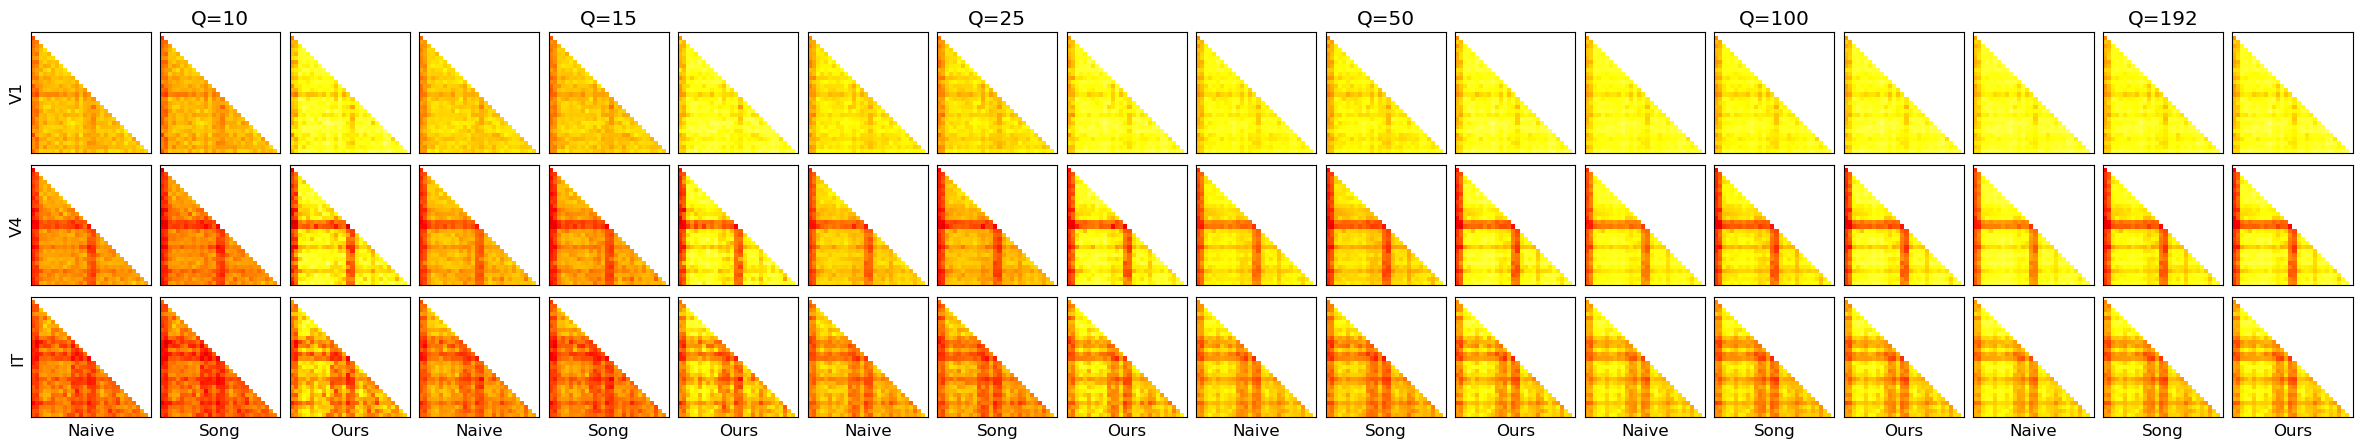

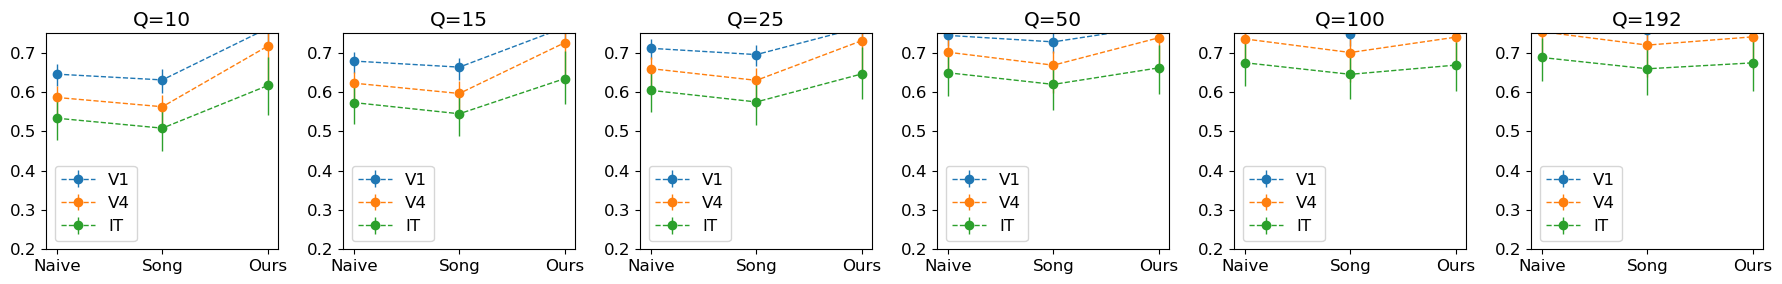

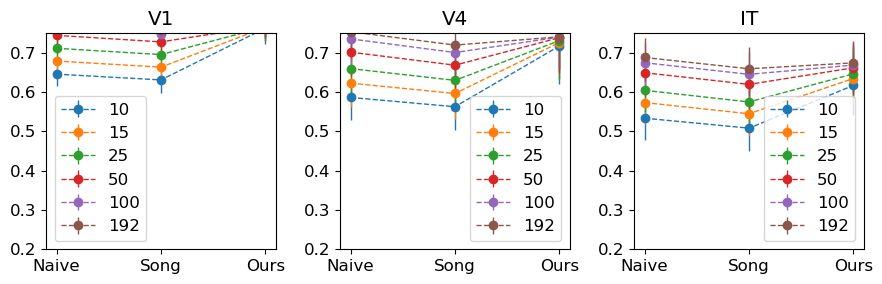

In [40]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

fig, axs = plt.subplots(3, len(Q_values)*3, figsize=(5*len(Q_values), 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

for q_idx, Q in enumerate(Q_values):
    for i, roi_name in enumerate(roi_names):
        for j, est_name in enumerate(['Naive', 'Song', 'Ours']):
            # Get data for specific Q value
            im = trial_ckas[roi_name][q_idx, :, :, :, j].mean(-1)

            col_idx = q_idx*3 + j
            axs[i, col_idx].imshow(im, cmap='hot', interpolation='nearest', vmin=0, vmax=1)

            # Add labels
            axs[i, 0].set_ylabel('{}'.format(roi_name))
            axs[-1, col_idx].set_xlabel('{}'.format(est_name))

            # Add Q value label for top row
            if i == 0:
                axs[i, col_idx].set_title(f'Q={Q}' if j == 1 else '')

            # Remove ticks
            axs[i, col_idx].set_xticks([])
            axs[i, col_idx].set_yticks([])
plt.show()


fig, axs = plt.subplots(1, len(Q_values), figsize=(3*len(Q_values), 3))
for q_idx, Q in enumerate(Q_values):
    ax = axs[q_idx]
    for i, roi_name in enumerate(roi_names):
        color = f'C{i}'

        im = trial_ckas[roi_name][q_idx].mean(-2)
        im = im.reshape(-1, 3)

        yval = np.nanmedian(im, axis=0)
        lower_error = np.nanquantile(im, axis=0, q=0.25)
        upper_error = np.nanquantile(im, axis=0, q=0.75)
        asymmetric_error = [yval-lower_error, upper_error-yval]
        ax.errorbar(np.arange(3), yval, yerr=asymmetric_error, c=color,
                    marker='o', ls='--', alpha=1, lw=1, zorder=0,
                    label=roi_name)

        ax.set_ylim([0.2, 0.75])
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['Naive', 'Song', 'Ours'])
        ax.set_title(f'Q={Q}')

    ax.legend()
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, len(roi_names), figsize=(3*len(roi_names), 3))
for i, roi_name in enumerate(roi_names):
    ax = axs[i]

    for q_idx, Q in enumerate(Q_values):
        color = f'C{q_idx}'

        im = trial_ckas[roi_name][q_idx].mean(-2)
        im = im.reshape(-1, 3)

        yval = np.nanmedian(im, axis=0)
        lower_error = np.nanquantile(im, axis=0, q=0.25)
        upper_error = np.nanquantile(im, axis=0, q=0.75)
        asymmetric_error = [yval-lower_error, upper_error-yval]
        ax.errorbar(np.arange(3), yval, yerr=asymmetric_error, c=color,
                    marker='o', ls='--', alpha=1, lw=1, zorder=0,
                    label=Q)

        ax.set_ylim([0.2, 0.75])
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['Naive', 'Song', 'Ours'])
        ax.set_title(f'{roi_name}')

    ax.legend()
plt.tight_layout()
plt.show()

(6, 30, 30, 15, 3)
(6, 900, 3)
(6, 30, 30, 15, 3)
(6, 900, 3)
(6, 30, 30, 15, 3)
(6, 900, 3)


/tmp/ipykernel_1556438/44883290.py:9: RuntimeWarning: Mean of empty slice
  im = np.nanmean(trial_ckas[roi_name], -2)


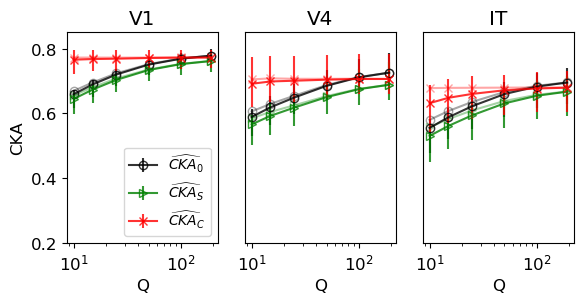

In [41]:
plt.rcParams.update({'font.size': 12})

#fig, axs = plt.subplots(1, len(roi_names), figsize=(3*len(roi_names), 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
fig, axs = plt.subplots(1, 3, figsize=(6,3.2))
for i, roi_name in enumerate(roi_names):
    ax = axs[i]

    print(trial_ckas[roi_name].shape)
    im = np.nanmean(trial_ckas[roi_name], -2)
    im = im.reshape(len(Q_values), -1, 3)
    print(im.shape)

    im_un = trial_ckas_N_Q[roi_name].reshape(len(Q_values), -1, 3)
    im_un = np.nanmean(im_un, axis=1)

    for j in range(3):
        color = f'C{j}'

        if j == 0:
            label = r'$\widehat{CKA}_0$'
            colorv = 'k'
            marker = 'o'
        elif j == 1:
            label = r'$\widehat{CKA}_S$'
            colorv = 'g'
            marker = '>'
        else:
            label = r'$\widehat{CKA}_C$'
            colorv = 'r'
            marker = 'x'

        yval = np.nanmean(im[:, :, j], axis=1)
        lower_error = np.nanquantile(im[:, :, j], axis=1, q=0.25)
        upper_error = np.nanquantile(im[:, :, j], axis=1, q=0.75)
        asymmetric_error = np.array([yval-lower_error, upper_error-yval])
        ax.errorbar(Q_values, yval, yerr=np.where(asymmetric_error>0,asymmetric_error,0), c=colorv,
                    marker=marker, ls='-', alpha=0.8, lw=1.5, zorder=0,
                    label=label,fillstyle='none')

        ax.plot(Q_values, im_un[:, j], c=colorv,
                marker=marker, ls='-', alpha=.35, lw=1.5, zorder=0,fillstyle='none')

    if i == 0:
        ax.legend(loc='lower right',fontsize=10)
        ax.set_ylabel('CKA')#, fontsize=12)
    else:
        axs[i].set_yticks([])
    ax.set_ylim([0.2, 0.85])

    ax.set_title(f'{roi_name}')#, fontsize=12)
    ax.set_xlabel('Q')#, fontsize=12)

    ax.set_xscale('log')

plt.tight_layout()
# plt.gcf().set_size_inches(12, 4)
# plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)


plt.savefig('./figures/trial_to_trial_comparison_{}.pdf'.format(sub_name), bbox_inches='tight')
plt.show()

In [ ]:
sub_name = 'F'

Q_values = [15, 25, 50, 100, 192]
num_repeat = 10

trial_ckas = {}
for roi_name in roi_names:

    roi = roi_data[sub_name][roi_name]
    roi -= roi.mean(-1, keepdims=True)
    print(roi.shape)

    trial_cka_Q = []
    for Q in Q_values:
        trial_cka = []
        for i in range(30):
            for j in range(30):

                if i < j:
                    trial_cka.append(np.ones((num_repeat, 3, 3))*np.nan)
                    continue

                trials = []
                for k in range(num_repeat):

                    idx_Q = np.random.choice(np.arange(roi.shape[1]), Q, replace=False)

                    Phi_a = roi[:, :, i][:, idx_Q]
                    Phi_b = roi[:, :, j][:, idx_Q]

                    # Calculate estimated numerator using Naive, Song and ours
                    num = list(getest_all(Phi_a, Phi_b, indep_cols=False))

                    # Calculate estimated denominators using Naive, Song and ours
                    denom1 = list(getest_all(Phi_a, Phi_a, indep_cols=False))
                    denom2 = list(getest_all(Phi_b, Phi_b, indep_cols=False))

                    trials.append([num, denom1, denom2])

                trial_cka.append(trials)

        trial_cka = np.array(trial_cka).reshape(30, 30, num_repeat, 3, 3)
        trial_cka = trial_cka[:, :, :, 0, :] / np.sqrt(trial_cka[:, :, :, 1, :] * trial_cka[:, :, :, 2, :])
        trial_cka_Q.append(trial_cka)

    trial_ckas[roi_name] = np.array(trial_cka_Q)

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

fig, axs = plt.subplots(3, len(Q_values)*3, figsize=(5*len(Q_values), 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

for q_idx, Q in enumerate(Q_values):
    for i, roi_name in enumerate(roi_names):
        for j, est_name in enumerate(['Naive', 'Song', 'Ours']):
            # Get data for specific Q value
            im = trial_ckas[roi_name][q_idx, :, :, :, j].mean(-1)

            col_idx = q_idx*3 + j
            axs[i, col_idx].imshow(im, cmap='hot', interpolation='nearest', vmin=0, vmax=1)

            # Add labels
            axs[i, 0].set_ylabel('{}'.format(roi_name))
            axs[-1, col_idx].set_xlabel('{}'.format(est_name))

            # Add Q value label for top row
            if i == 0:
                axs[i, col_idx].set_title(f'Q={Q}' if j == 1 else '')

            # Remove ticks
            axs[i, col_idx].set_xticks([])
            axs[i, col_idx].set_yticks([])
plt.show()


fig, axs = plt.subplots(1, len(Q_values), figsize=(3*len(Q_values), 3))
for q_idx, Q in enumerate(Q_values):
    ax = axs[q_idx]
    for i, roi_name in enumerate(roi_names):
        color = f'C{i}'

        im = trial_ckas[roi_name][q_idx].mean(-2)
        im = im.reshape(-1, 3)

        yval = np.nanmedian(im, axis=0)
        lower_error = np.nanquantile(im, axis=0, q=0.25)
        upper_error = np.nanquantile(im, axis=0, q=0.75)
        asymmetric_error = [yval-lower_error, upper_error-yval]
        ax.errorbar(np.arange(3), yval, yerr=asymmetric_error, c=color,
                    marker='o', ls='--', alpha=1, lw=1, zorder=0,
                    label=roi_name)

        # ax.set_ylim([0.2, 0.75])
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['Naive', 'Song', 'Ours'])
        ax.set_title(f'Q={Q}')

    ax.legend()
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, len(roi_names), figsize=(3*len(roi_names), 3))
for i, roi_name in enumerate(roi_names):
    ax = axs[i]

    for q_idx, Q in enumerate(Q_values):
        color = f'C{q_idx}'

        im = trial_ckas[roi_name][q_idx].mean(-2)
        im = im.reshape(-1, 3)

        yval = np.nanmedian(im, axis=0)
        lower_error = np.nanquantile(im, axis=0, q=0.25)
        upper_error = np.nanquantile(im, axis=0, q=0.75)
        asymmetric_error = [yval-lower_error, upper_error-yval]
        ax.errorbar(np.arange(3), yval, yerr=asymmetric_error, c=color,
                    marker='o', ls='--', alpha=1, lw=1, zorder=0,
                    label=Q)

        # ax.set_ylim([0.2, 0.75])
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['Naive', 'Song', 'Ours'])
        ax.set_title(f'{roi_name}')

    ax.legend()
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, len(roi_names), figsize=(3*len(roi_names), 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for i, roi_name in enumerate(roi_names):
    ax = axs[i]

    print(trial_ckas[roi_name].shape)
    im = trial_ckas[roi_name].mean(-2)
    im = im.reshape(len(Q_values), -1, 3)
    print(im.shape)

    for j in range(3):
        color = f'C{j}'

        if j == 0:
            label = '$\widehat{CKA}_0$'
        elif j == 1:
            label = '$\widehat{CKA}_S$'
        else:
            label = '$\widehat{CKA}_C$'

        yval = np.nanmedian(im[:, :, j], axis=1)
        lower_error = np.nanquantile(im[:, :, j], axis=1, q=0.25)
        upper_error = np.nanquantile(im[:, :, j], axis=1, q=0.75)
        asymmetric_error = [yval-lower_error, upper_error-yval]
        ax.errorbar(Q_values, yval, yerr=asymmetric_error, c=color,
                    marker='o', ls='--', alpha=1, lw=1, zorder=0,
                    label=label)

    if i == 0:
        ax.legend(loc='lower right')
        ax.set_ylabel('CKA')
    else:
        # Remove ticks
        # axs[i].set_xticks([])
        axs[i].set_yticks([])
    # ax.set_ylim([0.2, 0.75])

    ax.set_title(f'{roi_name}')
    ax.set_xlabel('Q')

plt.tight_layout()
plt.savefig('./figures/trial_to_trial_noise_comparison.pdf')
plt.show()